# EnvisionBOX Summer School 2025, Day 4: Bringing all together
## Data Analysis

At this point, we have one file with all signals and annotations that are relevant for us per each trial. Now the ways will diverge depending on what questions we want to ask.

Are we still interested in the temporal characteristics of the **whole** signal or its shape, maybe in relation to other trials? Then we will probably continue working with the whole timeseries.

Do we need to get information from the signal that will represent the trial's temporal and/or other aspect? Then we most likely can collect the information into a **flat** dataframe, where we no longer have the time dimension, but rather a set of features that describe the trial.

In [3]:
# Import packages
import os
import glob
import pandas as pd
from scipy.signal import find_peaks
import numpy as np
import antropy as ent
import matplotlib.pyplot as plt

curfolder = os.getcwd()

# Here we store our merged final timeseries data
datafolder = os.path.join(curfolder, 'TS_annotated')
filestotrack = glob.glob(os.path.join(datafolder, '*.csv'))

## Timeseries analysis

In some cases, the varying signals are your end goal and you want to analyze them in their temporal complexity as a whole. For example, you would want to work with the whole signal if you are interested in questions like:

- How similar two signals are (esp. in shape)? <br>
- How synchronized two signals are (within and between persons)? <br>

Possible directions of timeseries analysis include:

- **synchrony analysis within person**: https://www.envisionbox.org/embedded_CrossWavelet_SG_synchrony.html
- **synchrony analysis between persons**: https://www.envisionbox.org/embedded_interpersonal_synchrony.html
- **non-linear time series analysis**: https://wimpouw.github.io/InterPerDynPipeline/
- **similarity analysis**: https://www.envisionbox.org/embedded_Gesture_kinematic_spaces.html

But very often, we can further simplify the work with the data because we are insterested in some specific characteristics of the signal. So we look on the shape and try to extract one or few numbers that characterize the whole signal in some (reducing) way.

Looking at the signal below, can you come up with some examples?

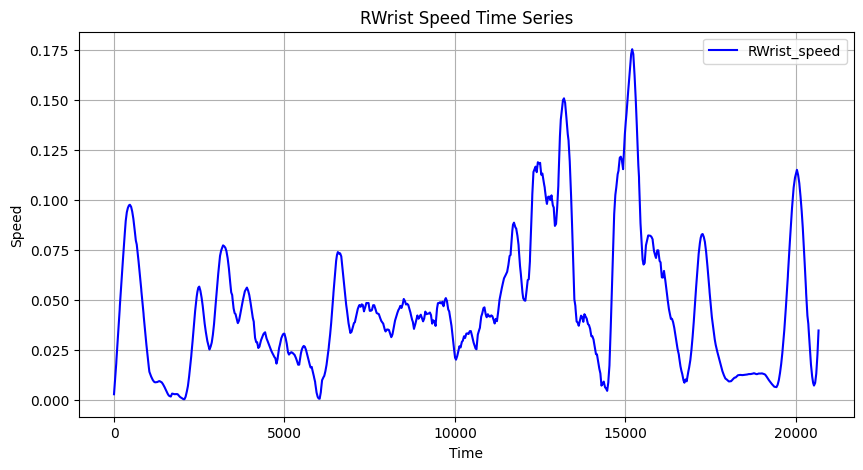

In [4]:
sample = filestotrack[0]
sample_df = pd.read_csv(sample, index_col=0)

# Plot RWrist_speed
plt.figure(figsize=(10, 5))
plt.plot(sample_df['RWrist_speed'], label='RWrist_speed', color='blue')
plt.title('RWrist Speed Time Series')
plt.xlabel('Time')
plt.ylabel('Speed')
plt.legend()
plt.grid()
plt.show()


## Flat data analysis

What we want to do now is create one master dataframe with some information about the signal for each trial. What information again depends on the questions we want to ask. You could keep it very simple and extract one or few features from the signals because this is what you need, or you want to be a bit megalomaniac or maybe you are not necessarily sure what feature would capture some difference between trials, or participants, or conditions, so you decide to extract a lot of features and work with multi-dimensional matrix of features.

Things you could collect when it comes to gestural & spoken behaviour include:

- basic statistics (mean, std, ...)
- gesture/vocal space
- complexity measures ~ intermittency, entropy, temporal variability, number of principal components (via PCA), ...

And many more...

In [5]:
# Import packages
import os
import glob
import pandas as pd
from scipy.signal import find_peaks
import numpy as np
import antropy as ent
import matplotlib.pyplot as plt

curfolder = os.getcwd()

# Here we store our merged final timeseries data
datafolder = os.path.join(curfolder, 'TS_annotated')
filestotrack = glob.glob(os.path.join(datafolder, '*.csv'))

To work with cleaner code, we will first create some functions that we then just reuse

In [6]:
# Function to calculate stats for a feature
def get_statistics(cols, df, subdf, dictionary):
    for col in cols:
        Gmean = subdf[col].mean()   # General mean
        Gstd = subdf[col].std()     # General std

        # If the col is 2nd derivative of position data, joint kinematics, or moments, we will calculate both positive and negative peaks (by reversing the sign of the data)
        if 'acc' in col:
            pospeaks, _ = find_peaks(subdf[col])
            pospeaks_values = df.loc[pospeaks, col]
            pospeaks_times = df.loc[pospeaks, "Time"].tolist()

            negpeaks, _ = find_peaks(-subdf[col])
            negpeaks_values = df.loc[negpeaks, col]
            negpeaks_times = df.loc[negpeaks, "Time"].tolist()

            negpeak_mean = negpeaks_values.mean()
            negpeak_std = negpeaks_values.std()
            negpeak_n = len(negpeaks_values)

        else:    
            pospeaks, _ = find_peaks(subdf[col])

            pospeaks_values = df.loc[pospeaks, col] # Peak values
            pospeaks_times = df.loc[pospeaks, "Time"].tolist() # Peak time

            # Plot if needed
            # peak_times = subdf.iloc[pospeaks]['time']
            # peak_values = subdf.iloc[pospeaks][col]
            # plt.plot(subdf['time'], subdf[col], label="Signal")
            # plt.scatter(peak_times, peak_values, color='r', label="Pos Peaks", marker="x")
            # plt.title(col)
            # plt.legend()
            # plt.show()

            pospeak_mean = pospeaks_values.mean() # Peak mean
            pospeak_std = pospeaks_values.std()   # Peak std
            pospeak_n = len(pospeaks_values)      # Number of peaks

            negpeak_mean = None
            negpeak_std = None
            negpeak_n = None
            negpeaks_times = None

        integral = np.trapz(subdf[col]) # Integral
        range = subdf[col].max() - subdf[col].min() # Range
        
        # Save all in dictionary
        dictionary[col] = [Gmean, Gstd, pospeak_mean, pospeak_std, pospeak_n, pospeaks_times, negpeak_mean, negpeak_std, negpeak_n, negpeaks_times, integral, range]

    return dictionary

# Function to adapt row
def adapt_row(row_to_process):
    for col in row_to_process.columns:
        # Calculate for all expcet some already calculated measures
        if 'inter' not in col and 'sampen' not in col and 'bbmv' not in col and 'duration' not in col and 'arms_submov' not in col and 'movid' not in col:
            row_to_process[col + '_Gmean'] = row_to_process[col].apply(lambda x: x[0])
            row_to_process[col + '_Gstd'] = row_to_process[col].apply(lambda x: x[1])
            row_to_process[col + '_pospeak_mean'] = row_to_process[col].apply(lambda x: x[2])
            row_to_process[col + '_pospeak_std'] = row_to_process[col].apply(lambda x: x[3])
            row_to_process[col + '_pospeak_n'] = row_to_process[col].apply(lambda x: x[4])
            row_to_process[col + '_pospeak_times'] = row_to_process[col].apply(lambda x: x[5])
            row_to_process[col + '_negpeak_mean'] = row_to_process[col].apply(lambda x: x[6])
            row_to_process[col + '_negpeak_std'] = row_to_process[col].apply(lambda x: x[7])
            row_to_process[col + '_negpeak_n'] = row_to_process[col].apply(lambda x: x[8])
            row_to_process[col + '_negpeak_times'] = row_to_process[col].apply(lambda x: x[9])
            row_to_process[col + '_integral'] = row_to_process[col].apply(lambda x: x[10])
            row_to_process[col + '_range'] = row_to_process[col].apply(lambda x: x[11])

    # Now keep only this newly created cols
    row_final = row_to_process[[col for col in row_to_process.columns if any(x in col for x in ['Gmean', 'Gstd', 'pospeak_mean', 'pospeak_std', 'pospeak_n', 'sampen', 'inter', 'integral', 'pospeak_times', 'bbmv', 'range', 'duration', 'negpeak_mean', 'negpeak_std', 'negpeak_n', 'negpeak_times', 'arms_submov', 'movid'])]]

    # Get rid of cols with NaNs
    row_final = row_final.dropna(axis=1, how='all')
    
    return row_final

Now you could add any other potential functions that take in a timeseries of sound/movement and return a single value or a set of features.

For more, you can check here: https://sarkadava.github.io/FLESH_Effort/07_TS_featureExtraction/TS_extraction.html

In [7]:
# Function to calcuate bounding box of movement volume     
def get_bbmv(df, group, kp_dict):
    coordinates = [col for col in df.columns if any(x in col for x in ['_x', '_y', '_z'])]

    # Prepare columns that belong to a group (e.g., arm)
    kp = kp_dict[group]
    colstoBBMV = [col for col in coordinates if any(x in col for x in kp)]

    # Keep only unique names without coordinates
    kincols = list(set([col.split('_')[0] for col in colstoBBMV]))

    bbmvs = {}
    for col in kincols:
        # Span of x, y, z
        x_span = df[col + '_x'].max() - df[col + '_x'].min()
        y_span = df[col + '_y'].max() - df[col + '_y'].min()
        z_span = df[col + '_z'].max() - df[col + '_z'].min()

        # Calculate BBMV
        bbmv = x_span * y_span * z_span
        bbmvs[col] = bbmv
        
    # Get the sum for the whole group
    bbmv_sum = sum(bbmvs.values())

    # Natural logarithm
    bbmv_sum = np.log(bbmv_sum) 

    return bbmv_sum

In [ ]:
# Function to calculate intermittency 
def get_intermittency(jerk_values, speed_values):

    smoothed_jerk = jerk_values
    speed = speed_values
    
    if not np.all(speed == 0):
        integrated_squared_jerk = np.sum(smoothed_jerk ** 2)
        max_squared_speed = np.max(speed ** 2)
        D3 = len(speed) ** 3
        jerk_dimensionless = integrated_squared_jerk * (D3 / max_squared_speed)
        smoothness = jerk_dimensionless
    else:
        smoothness = np.nan

    return smoothness

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# Initialize the dataframe
features_df = pd.DataFrame()

##########################
##### preparations #######
##########################

# These are groups of keypoints belonging to one body part
kp_arms = ['RWrist', 'RElbow', 'RShoulder', 'LWrist', 'LElbow', 'LShoulder']
kp_lower = ['RAnkle', 'RKnee', 'LAnkle', 'LKnee']
kp_legs = ['RAnkle', 'RKnee', 'LAnkle', 'LKnee']
kp_head = ['Head']
kp_keys = {'arm': kp_arms, 'lowerbody': kp_lower, 'leg': kp_legs, 'head': kp_head}

##########################
####### main loop ########
##########################

file_id = 1

for file in filestotrack:
    fileid = os.path.basename(file).split('.')[0]  # Get the file ID from the filename
    print('working on file: ', fileid)
    df = pd.read_csv(file)

    # Add gesture annotation ID, such that everytime a value changes, we increment the ID
    df["GestureID"] = (df["Gesture"] != df["Gesture"].shift()).cumsum()

    # chunk the df in chunks according to GestureID
    df_chunks = [group for _, group in df.groupby("GestureID")]

    # into movchunks add all chunks where Gesture has value Move
    movchunks = [group for group in df_chunks if group["Gesture"].values[0] == "Move"]
    geschunks = [group for group in df_chunks if group["Gesture"].values[0] == "Gesture"]

    choi = movchunks + geschunks

    chunk_id = 1 

    #### Gesture-speech synchrony intermezzo ####
    # Collect peaks in envelope - Question: Why here?
    if 'envelope' in df.columns:
        peaks, _ = find_peaks(df['envelope'])
        envpeaks_v = df.loc[peaks, 'envelope'].tolist()
        envpeaks_t = df.loc[peaks, 'Time'].tolist()
    
    #### Full loop ####
    for ch in choi:
        
        subdf = ch
        sumfeat = {}

        # if Gesture value is Gesture, mov_id == gesture, else mov
        if subdf["Gesture"].values[0] == "Gesture":
            movid = f'{file_id}_gesture_{chunk_id}'
        else:
            movid = f'{file_id}_mov_{chunk_id}'

        if subdf.shape[0] == 0:
            print("Empty chunk, skipping")
            continue

        else:
            colstosum = [col for col in subdf.columns if 'Time' not in col and 'file' not in col and 'audio' not in col and 'Gesture' not in col and 'GestureID' not in col]
            # Get stats
            sumfeat = get_statistics(colstosum, df, subdf, sumfeat)
            # Get duration
            duration = subdf["Time"].iloc[-1] - subdf["Time"].iloc[0]
            sumfeat['duration'] = duration
            # Get intermittency for RWrist
            if 'RWrist_speed' in subdf.columns and 'RWrist_jerk' in subdf.columns:
                speed = subdf['RWrist_speed'].values
                jerk = subdf['RWrist_jerk'].values
                intermittency = get_intermittency(jerk, speed)
                intermittency = np.log(intermittency)
                sumfeat['RWrist_inter'] = intermittency

            else:
                print("RWrist speed or jerk not found, skipping intermittency calculation")
                sumfeat['RWrist_inter'] = np.nan
                
            # Get sample entropy for RWrist
            if 'RWrist_speed' in subdf.columns:
                sampEn = ent.sample_entropy(subdf['RWrist_speed'].values, 2, 0.2 * np.std(subdf['RWrist_speed'].values))
                sumfeat['RWrist_sampen'] = sampEn

            # Get BBMV for each group
            for group in kp_keys.keys():
                bbmv_sum = get_bbmv(subdf, group, kp_keys)
                sumfeat[group + '_bbmv'] = bbmv_sum

            # Number of submovements
            submovcols = [col for col in subdf.columns if "Wrist" in col and 'speed' in col]
            arms_submov = []
  
            for col in submovcols:
                # Calculate the number of peaks that delimit unique submovements
                peaks, _ = find_peaks(subdf[col])
                arms_submov.append(len(peaks))

            sumfeat['arms_submov'] = np.sum(arms_submov)
            sumfeat['movid'] = movid

            # Make a row
            sumfeat_row = pd.DataFrame({key: [value] for key, value in sumfeat.items()})
            sumfeat_row = adapt_row(sumfeat_row)
        
            
            ##### Gesture-speech synchrony features #####
            # get peaks in RWrist_acc and find the closest to envpeaks_t
            if 'RWrist_acc' in subdf.columns and 'envelope' in df.columns:
                rwrist_peaks, _ = find_peaks(subdf['RWrist_acc'])
                rwrist_peaks_times = df.loc[rwrist_peaks, 'Time'].tolist()

                if len(rwrist_peaks_times) == 0:
                    sumfeat_row['RWrist_acc_env_sync'] = None
                    continue

                else:
                    # Find the closest RWrist peak to each envelope peak
                    sync_list = []
                    for accpeak in rwrist_peaks_times:
                        # Find the closest envelope peak
                        closest_env_peak = min(envpeaks_t, key=lambda x: abs(x - accpeak))
                        # calculate synchrony as the time difference
                        synchrony = abs(closest_env_peak - accpeak)
                        sync_list.append(synchrony)
            
                    sumfeat_row['RWrist_acc_env_sync'] = [sync_list]

            else:
                sumfeat_row['RWrist_acc_env_sync'] = None
            
            # Concat the new row to the features_df
            if features_df.empty:
                features_df = sumfeat_row
            else:
                features_df = pd.concat([features_df, sumfeat_row], ignore_index=True)

        # Add fileid to the df
        features_df['fileid'] = fileid
    
        chunk_id += 1

    file_id += 1   


# Round all num cols to 3
numcols = features_df.select_dtypes(include=[np.number]).columns
features_df[numcols] = features_df[numcols].round(3)


working on file:  annotated_femalemonologue2_t3_0-619


In [40]:
features_df.head(59)

,duration,RWrist_inter,RWrist_sampen,arm_bbmv,lowerbody_bbmv,leg_bbmv,head_bbmv,arms_submov,movid,RHip_x_Gmean,...,RHip_jerk_pospeak_std,Nose_speed_pospeak_std,Nose_acc_pospeak_std,Nose_acc_negpeak_std,Nose_jerk_pospeak_std,LElbow_jerk_pospeak_std,LShoulder_acc_negpeak_std,LShoulder_jerk_pospeak_std,LWrist_speed_pospeak_std,LWrist_acc_pospeak_std
0,600.000,13.045,0.034,6.297,5.836,5.836,2.342,3,1_mov_1,-254.909,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,520.000,11.455,0.025,6.364,6.099,6.099,1.547,2,1_mov_2,-267.857,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,920.000,13.156,0.116,6.918,5.358,5.358,5.643,7,1_mov_3,-275.858,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,840.000,15.171,0.028,9.906,8.816,8.816,7.273,2,1_gesture_4,-281.960,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,280.000,9.645,0.018,4.705,4.156,4.156,-1.545,1,1_gesture_5,-256.477,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,480.000,12.136,0.021,8.302,5.477,5.477,4.593,2,1_gesture_6,-284.522,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2600.000,18.895,0.020,12.952,12.020,12.020,10.009,17,1_gesture_7,-327.991,...,0.0,0.004,0.004,0.001,0.0,0.0,0.0,0.0,0.346,0.346
7,1126.667,17.060,0.030,10.855,4.781,4.781,2.877,2,1_gesture_8,-284.471,...,0.0,0.003,0.003,0.001,NaN,NaN,0.0,NaN,NaN,NaN


So now we end up with nice dataframe that is ready to be visualized, inspected, analyzed...

Possible next steps depends on whether we now want to...

1. visually inspect the data
<br>
~ UMAP <br>
~ Dashboard (or Shiny in R), https://tsg-131-174-75-200.hosting.ru.nl/dimsvisualizer/
<br>
2. analyze the data in confirmatory way
<br>
~ Reducing dataframe into features of interest --> statistical modeling

3. analyze the data in exploratory (or exploratory-confirmatory) way
<br>
~ PCA<br>
~ t-SNE or UMAP for non-linearity<br>
~ XGBoost for robust classification<br>
~ vector embeddings<br>


## Example 1: PCA

In [ ]:
# We first need to create column that will represent the categories we are interested in - let's say movement vs gesture
features_df['category'] = features_df['movid'].apply(lambda x: 'gesture' if 'gesture' in x else 'movement')

# Save the values in separate vector
category = features_df['category']

# in features_df, keep only numerical cols
features_df = features_df.select_dtypes(include=['float64','int64'])

# Add the category column to the features_df
features_df['category'] = category


### Handling missing values

In [8]:
# fill in with 0
features_df = features_df.fillna(0)

In [9]:
import plotly.graph_objects as go
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

# Prepare data
X = features_df.iloc[:, :-1].values  # All columns except the last as features
y = features_df.iloc[:, -1].values   # Last column as target variable

# Convert categorical target to numeric if necessary
if y.dtype == 'object' or y.dtype.name == 'category':
    le = LabelEncoder()
    y = le.fit_transform(y)  # Converts categorical labels into numeric labels

# Scale the data
scaler = StandardScaler()
X = scaler.fit_transform(X)    

# PCA transformation
pca = PCA()
x_new = pca.fit_transform(X)

# Get the PCA loadings (components_ is shape: [n_components, n_features])
loadings = pca.components_


In [24]:
def get_PCA(df):
    # Step 1: Standardize the Data
    scaler = StandardScaler()
    standardized_data = scaler.fit_transform(df)
    
    # Step 2: Apply PCA
    pca = PCA()
    pca.fit(standardized_data)
    
    # Step 3: Explained Variance
    explained_variance = pca.explained_variance_ratio_
    cumulative_explained_variance = explained_variance.cumsum()

    # Step 4: Find the number of components that explain 95% variance
    n_components_for_80_variance = np.argmax(cumulative_explained_variance >= 0.8) + 1
    
    # Step 5: Compute the slope for the first n_components_for_95_variance
    if n_components_for_80_variance > 1:
        slope_80 = (cumulative_explained_variance[n_components_for_80_variance-1] - cumulative_explained_variance[0]) / (n_components_for_80_variance - 1)
    else:
        slope_80 = cumulative_explained_variance[0]  # Only one component case

    # 95% variance
    n_components_for_95_variance = np.argmax(cumulative_explained_variance >= 0.95) + 1
    
    # Step 5: Compute the slope for the first n_components_for_95_variance
    if n_components_for_95_variance > 1:
        slope_95 = (cumulative_explained_variance[n_components_for_95_variance-1] - cumulative_explained_variance[0]) / (n_components_for_95_variance - 1)
    else:
        slope_95 = cumulative_explained_variance[0]  # Only one component case


    #Optionally plot the cumulative explained variance
    plt.figure(figsize=(8, 6))
    plt.plot(cumulative_explained_variance, marker='o', label='Cumulative Explained Variance')
    plt.axvline(x=n_components_for_80_variance-1, color='red', linestyle='--', label=f'80% Variance at {n_components_for_80_variance} components')
    plt.axvline(x=n_components_for_95_variance-1, color='green', linestyle='--', label=f'95% Variance at {n_components_for_95_variance} components')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Cumulative Explained Variance by PCA')
    plt.grid(True)
    plt.legend()
    plt.show()

    return n_components_for_80_variance, slope_80, n_components_for_95_variance, slope_95


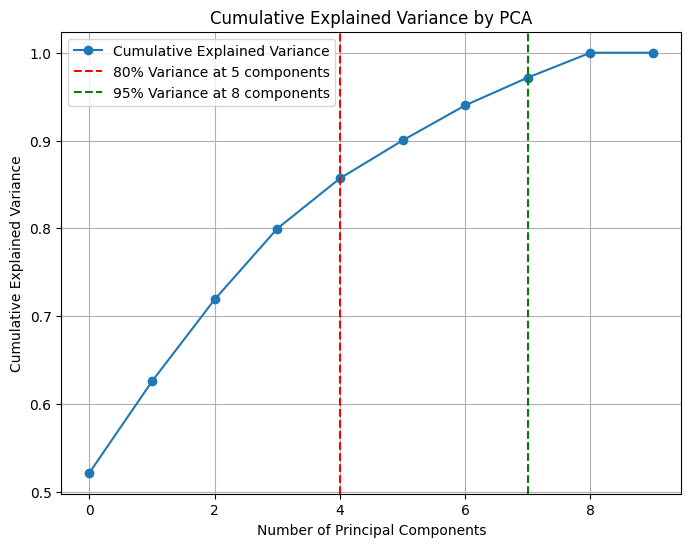

(5, 0.08381249579843059, 8, 0.06429708649727948)

In [25]:
# scree plot
get_PCA(features_df.iloc[:, :-1])

In [26]:
pca.explained_variance_ratio_

array([5.21626942e-01, 1.04166274e-01, 9.32482459e-02, 8.06918343e-02,
       5.71436288e-02, 4.32151224e-02, 3.99722794e-02, 3.16422206e-02,
       2.82934522e-02, 5.26953146e-32])

In [34]:
print(abs( pca.components_ ))

[[5.04369722e-02 4.36866625e-02 2.34801134e-04 ... 0.00000000e+00
  4.77685360e-02 4.77685360e-02]
 [8.87921213e-03 1.68002319e-02 2.32925066e-02 ... 0.00000000e+00
  2.40144166e-02 2.40144166e-02]
 [1.55291545e-02 5.78434141e-02 3.76882339e-02 ... 0.00000000e+00
  2.84642064e-02 2.84642064e-02]
 ...
 [1.16127946e-03 8.65306402e-03 4.86921027e-02 ... 0.00000000e+00
  5.23811870e-03 5.23811870e-03]
 [2.78500751e-03 1.38747021e-02 3.71697530e-02 ... 0.00000000e+00
  4.66639972e-03 4.66639972e-03]
 [7.87211622e-01 5.28945973e-02 4.47708127e-01 ... 0.00000000e+00
  8.79403554e-03 8.79403554e-03]]


In [35]:
# Number of principal components
n_pcs = 3

# Feature names (excluding target column)
feature_names = features_df.columns[:-1]  

# Create storage for the ordered feature names and loadings
results_dict = {}

for i in range(n_pcs):
    # Get all features sorted by absolute loading values
    sorted_indices = np.abs(pca.components_[i]).argsort()[::-1]
    sorted_features = feature_names[sorted_indices]  # Feature names
    sorted_loadings = pca.components_[i, sorted_indices]  # Loadings

    # Store in dictionary
    results_dict[f'PC{i+1}'] = sorted_features.values
    results_dict[f'PC{i+1}_Loading'] = sorted_loadings

# Convert dictionary to DataFrame
results_df = pd.DataFrame(results_dict)
results_df.head(50)


,PC1,PC1_Loading,PC2,PC2_Loading,PC3,PC3_Loading
0,LElbow_speed_integral,0.050838,LHip_jerk_integral,0.105746,RWrist_y_integral,0.114406
1,RWrist_speed_integral,0.050759,Neck_jerk_integral,0.103051,RElbow_y_integral,0.114183
2,Nose_x_integral,-0.050741,LShoulder_jerk_integral,0.102291,RShoulder_y_integral,0.113136
3,Head_x_integral,-0.050736,RHip_jerk_integral,0.098825,RWrist_z_Gmean,0.110101
4,RHip_x_integral,-0.050719,Nose_jerk_integral,0.098720,RHeel_y_integral,0.109887
5,Neck_x_integral,-0.050716,Head_jerk_integral,0.097733,RHip_y_integral,0.106650
6,LWrist_x_integral,-0.050709,LElbow_jerk_integral,0.097239,RAnkle_y_integral,0.106228
7,LElbow_x_integral,-0.050704,RKnee_jerk_integral,0.096478,RKnee_y_integral,0.105212
8,LAnkle_x_integral,-0.050702,Head_speed_Gmean,-0.092429,LAnkle_acc_negpeak_std,0.104168
9,LKnee_x_integral,-0.050700,RShoulder_jerk_integral,0.089531,LAnkle_jerk_integral,0.102462


In [60]:
# Number of top variables to show per PC
top_n = 10

# Get top variables per PC by absolute contribution
top_vars = set()
for i in range(2):  # for PC1, PC2, PC3
    component = loadings[i]
    top_indices = np.argsort(np.abs(component))[-top_n:]
    top_vars.update(top_indices)

# Convert to sorted list for consistency
selected_vars = sorted(top_vars)

def interactive_PCA_biplot(score, coeff, labels=None, y=None, selected_vars=None):
    xs = score[:, 0]
    ys = score[:, 1]

    # Create scatter plot for samples
    scatter = go.Scatter(
        x=xs,
        y=ys,
        mode='markers',
        marker=dict(
            size=8,
            color=y,
            colorscale='Viridis',
            showscale=True,
            colorbar=dict(title='Target')
        ),
        name='Samples',
        text=[f"Sample {i}" for i in range(len(xs))],
        hoverinfo='text'
    )

    # Create arrows for loadings
    arrows = []
    texts = []

    vars_to_plot = selected_vars if selected_vars is not None else range(coeff.shape[0])

    arrow_scale = 100

    for i in vars_to_plot:

        var_name = f"Var{i+1}" if labels is None else labels[i]
        
        arrows.append(
            go.Scatter(
                x=[0, coeff[i, 0] * arrow_scale],  # scale arrows for visibility
                y=[0, coeff[i, 1] * arrow_scale],
                mode='lines+markers',
                line=dict(color='red'),
                marker=dict(size=3),
                hovertext=var_name,  # FULL NAME here
                hoverinfo='text'
            )
        )

    layout = go.Layout(
        title="Interactive PCA Biplot",
        xaxis=dict(title='PC1'),
        yaxis=dict(title='PC2'),
        width=800,
        height=600,
        hovermode='closest',
        showlegend=False
    )

    fig = go.Figure(data=[scatter] + arrows + texts, layout=layout)
    fig.show()


In [61]:
# Plot
interactive_PCA_biplot(x_new[:, 0:2], np.transpose(pca.components_[0:2, :]),
                       labels=features_df.columns[:-1], y=y,
                       selected_vars=selected_vars)

In [55]:
import plotly.graph_objects as go
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def interactive_PCA_biplot_3D(score, coeff, labels=None, y=None, selected_vars=None):
    xs, ys, zs = score[:, 0], score[:, 1], score[:, 2]

    # Sample points
    scatter = go.Scatter3d(
        x=xs,
        y=ys,
        z=zs,
        mode='markers',
        marker=dict(
            size=5,
            color=y,
            colorscale='Viridis',
            opacity=0.8,
            colorbar=dict(title='Target')
        ),
        name='Samples',
        hoverinfo='text'
    )

    # Arrows (loadings)
    arrows = []

    vars_to_plot = selected_vars if selected_vars is not None else range(coeff.shape[0])
    arrow_scale = 100  # smaller in 3D

    for i in vars_to_plot:
        var_name = f"Var{i+1}" if labels is None else labels[i]
        arrows.append(
            go.Scatter3d(
                x=[0, coeff[0][i] * arrow_scale],
                y=[0, coeff[1][i] * arrow_scale],
                z=[0, coeff[2][i] * arrow_scale],
                mode='lines+markers',
                line=dict(color='red', width=4),
                marker=dict(size=3),
                hovertext=var_name,
                hoverinfo='text',
                name=var_name
            )
        )

    layout = go.Layout(
        title="Interactive 3D PCA Biplot",
        scene=dict(
            xaxis_title="PC1",
            yaxis_title="PC2",
            zaxis_title="PC3"
        ),
        width=900,
        height=700,
        showlegend=False
    )

    fig = go.Figure(data=[scatter] + arrows, layout=layout)
    fig.show()


In [56]:
# Number of top variables to show per PC
top_n = 3

# Get top variables per PC by absolute contribution
top_vars = set()
for i in range(3):  # for PC1, PC2, PC3
    component = loadings[i]
    top_indices = np.argsort(np.abs(component))[-top_n:]
    top_vars.update(top_indices)

# Convert to sorted list for consistency
selected_vars = sorted(top_vars)

interactive_PCA_biplot_3D(
    score=x_new,
    coeff=loadings,
    labels=features_df.columns[:-1],
    y=y,
    selected_vars=selected_vars
)

## Example 2: Gesture-speech synchrony in movement vs gesture

In [47]:
# create column to distinguish gesture from movement
features_df['anno_id'] = features_df['movid'].apply(lambda x: x.split('_')[1])
features_df['anno_id'] = features_df['anno_id'].astype('category')

# Plot RWrist_acc_env_sync per Gesture
fig = go.Figure()
for anno_id in features_df['anno_id'].unique():
    subset = features_df[features_df['anno_id'] == anno_id]
    fig.add_trace(go.Box(
        y=subset['RWrist_acc_env_sync'].apply(lambda x: x[0] if isinstance(x, list) else np.nan),
        name=anno_id,
        boxmean='sd'
    ))
fig.update_layout(
    title='RWrist_acc_env_sync per Gesture',
    xaxis_title='Gesture Annotation ID',
    yaxis_title='RWrist_acc_env_sync',
    boxmode='group'
)
fig.show()


Notes:

- UMAP - non-linear method, preserves both local and global structure, preserves local and gloval relationships (overal shape + clusters), output: coordinates/embeddings, stochastic ~ different results every time, due to randomizations, cluster sizes and distances are not meaningful!!!

- t-SNE - non-linear method, preserves local structure (neighborhoods), focuses on local relationships
 quite slow, output: coordinates/embeddings, stochastic ~ different results every time due to randomizations, cluster sizes and distances are not meaningful!!!

- PCA - linear method (linear transformation), focuses on maximizing variance (global structure), preserves variance (overall spread), output: principal components (PCs), deterministic ~ same results every time, (or see non-linear PCA)
